In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, LearningCurveDisplay, learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE

import shap
shap.initjs()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.expand_frame_repr', False)

# KDDCup1999

In [2]:
# KDDCup1999
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate"]
label = ["label"]
kdd_X_train = pd.read_csv('./data/kddcup/X_train_res.csv', index_col=False)
kdd_y_train = pd.read_csv('./data/kddcup/y_train_res.csv', index_col=False)
kdd_X_test = pd.read_csv('./data/kddcup/X_test.csv', index_col=False)
kdd_y_test = pd.read_csv('./data/kddcup/y_test.csv', index_col=False)

In [3]:
# CICIDS2017
cic_X_train = pd.read_csv('./data/cicids2017/X_train_resampled_scaled.csv', index_col=False)
cic_y_train = pd.read_csv('./data/cicids2017/y_train_resampled_scaled.csv', index_col=False)
cic_X_test = pd.read_csv('./data/cicids2017/X_test_scaled.csv', index_col=False)
cic_y_test = pd.read_csv('./data/cicids2017/y_test.csv', index_col=False)

In [4]:
print(f"KDD\n{kdd_y_train.value_counts()}\n\nCIC\n{cic_y_train.value_counts()}")

KDD
label
0        2748096
1        2748096
Name: count, dtype: int64

CIC
Attack Type
0              500000
1              500000
Name: count, dtype: int64


Labels:  
0 = normal  
1 = attack

In [5]:
print("Shape of Datasets")
print("-"*70)
print(f"Dataset\t\t|\tTraining set\t|\tTesting set")
print("-"*70)
print(f"KDDCup1999\t|\t{kdd_X_train.shape}\t|\t{kdd_X_test.shape}")
print(f"CICIDS2017\t|\t{cic_X_train.shape}\t|\t{cic_X_test.shape}")

Shape of Datasets
----------------------------------------------------------------------
Dataset		|	Training set	|	Testing set
----------------------------------------------------------------------
KDDCup1999	|	(5496192, 41)	|	(1469530, 41)
CICIDS2017	|	(1000000, 51)	|	(756226, 51)


## Select 15 best features

In [6]:
# KDD
selected_features = [
    'protocol_type', 'service', 'flag', 'logged_in', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate'
]
kdd_X_train_sel = kdd_X_train[selected_features]
kdd_X_test_sel = kdd_X_test[selected_features]

print("Original number of features:", kdd_X_train.shape[1])
print("Number of selected features:", kdd_X_train_sel.shape[1])
print("Number of training samples:", kdd_X_train_sel.shape[0])
print("Number of test samples:", kdd_X_test_sel.shape[0])

Original number of features: 41
Number of selected features: 15
Number of training samples: 5496192
Number of test samples: 1469530


In [7]:
# CIC
selected_features = ['Flow Duration',
 'Flow Bytes/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Fwd IAT Total',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Packet Length Variance',
 'Idle Mean',
 'Idle Max',
 'Idle Min']
cic_X_train_sel = cic_X_train[selected_features]
cic_X_test_sel = cic_X_test[selected_features]
print("Original number of features:", cic_X_train.shape[1])
print("Number of selected features:", cic_X_train_sel.shape[1])
print("Number of training samples:", cic_X_train_sel.shape[0])
print("Number of test samples:", cic_X_test_sel.shape[0])

Original number of features: 51
Number of selected features: 15
Number of training samples: 1000000
Number of test samples: 756226


## Scale data

In [8]:
def scale_data(X_train, X_test, y_train, scaler=StandardScaler()):
    X_train_scaled = scaler.fit_transform(X_train, y_train)
    X_test_scaled = scaler.fit_transform(X_test, y_test)
    return X_train_scaled, X_test_scaled

## Model Training

In [9]:
# Function to print classification reports and plot confusion matrix and ROC curve
def print_reports(clf, X_test, y_test, y_pred, classes, title):
    print(title)
    # print classification report
    print(classification_report(y_test, y_pred))
    
    print()
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print()
    
    # plot ROC curve
    roc_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test)

In [10]:
# Function to train model and print reports
def train_model(X_train, y_train, X_test, y_test, clf=SGDClassifier(), title='SGD Classifier Confusion Matrix'):
    clf.fit(X_train, y_train.values.ravel())
    pred = clf.predict(X_test)
    print_reports(clf, X_test, y_test, pred, ['Benign', 'Attack'], title)

### Baseline performance

KDDCup1999
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    291976
           1       1.00      0.94      0.97   1177554

    accuracy                           0.95   1469530
   macro avg       0.90      0.97      0.93   1469530
weighted avg       0.96      0.95      0.95   1469530




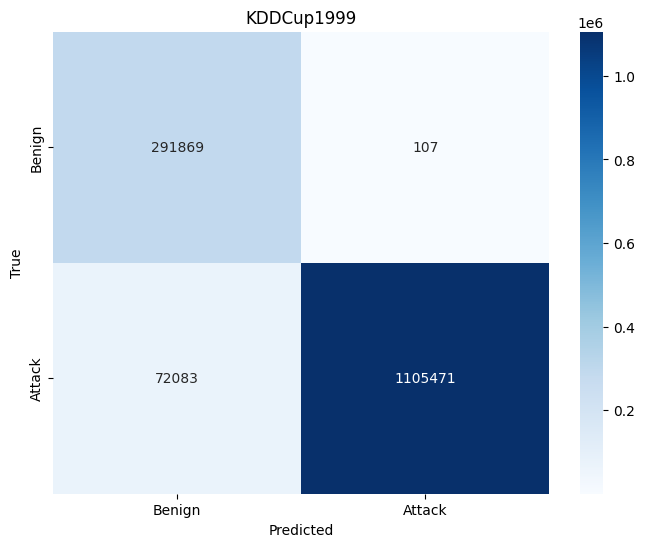

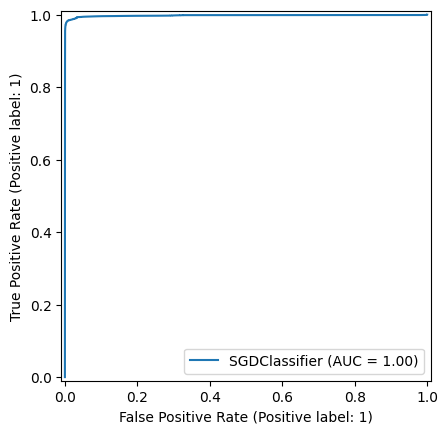

In [23]:
# KDD
clf = SGDClassifier(max_iter=1000)
train_model(kdd_X_train, kdd_y_train, kdd_X_test, kdd_y_test, clf, title='KDDCup1999')

CICIDS2017
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    628518
           1       0.81      0.91      0.86    127708

    accuracy                           0.95    756226
   macro avg       0.90      0.94      0.92    756226
weighted avg       0.95      0.95      0.95    756226




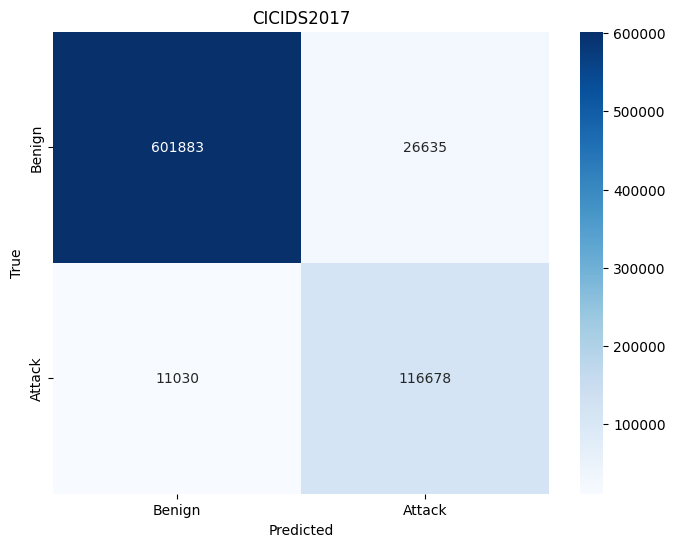

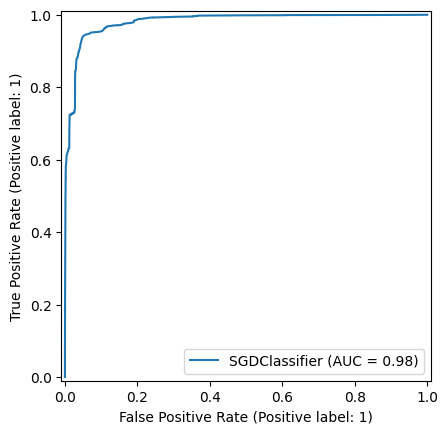

In [24]:
# CIC
train_model(cic_X_train, cic_y_train, cic_X_test, cic_y_test, clf, title='CICIDS2017')

### After feature selection and hyperparameter tuning

KDDCup1999 w/ 15 best features and hyperparameter tuning
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    291976
           1       1.00      0.99      0.99   1177554

    accuracy                           0.99   1469530
   macro avg       0.98      0.99      0.99   1469530
weighted avg       0.99      0.99      0.99   1469530




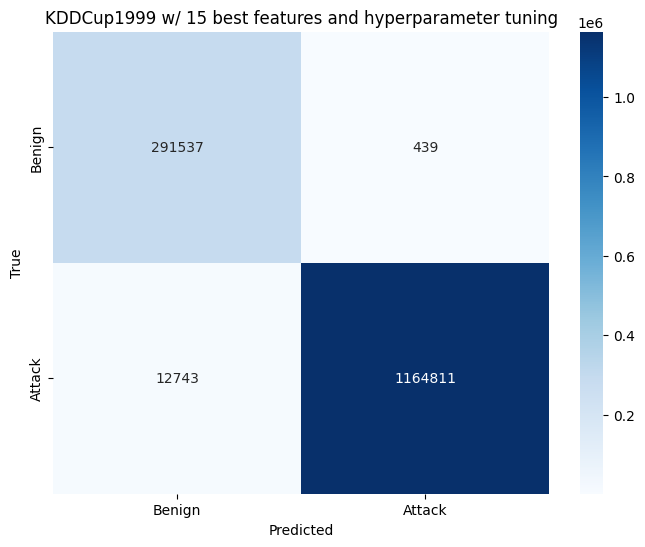

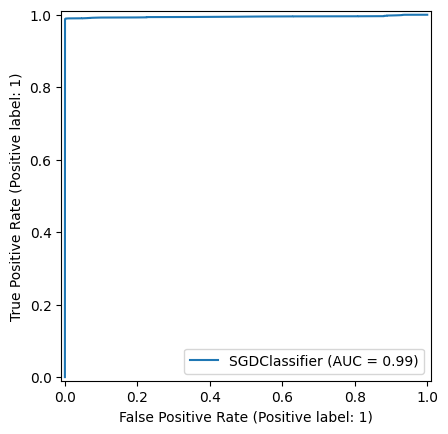

In [14]:
kdd_clf = SGDClassifier(max_iter=5000, penalty='elasticnet', loss='hinge', alpha=0.0001)
train_model(kdd_X_train_sel, kdd_y_train, kdd_X_test_sel, kdd_y_test, kdd_clf, title='KDDCup1999 w/ 15 best features and hyperparameter tuning')

CICIDS2017 w/ 15 best features and hyperparameter tuning
              precision    recall  f1-score   support

           0       0.93      0.97      0.95    628518
           1       0.84      0.66      0.74    127708

    accuracy                           0.92    756226
   macro avg       0.88      0.82      0.85    756226
weighted avg       0.92      0.92      0.92    756226




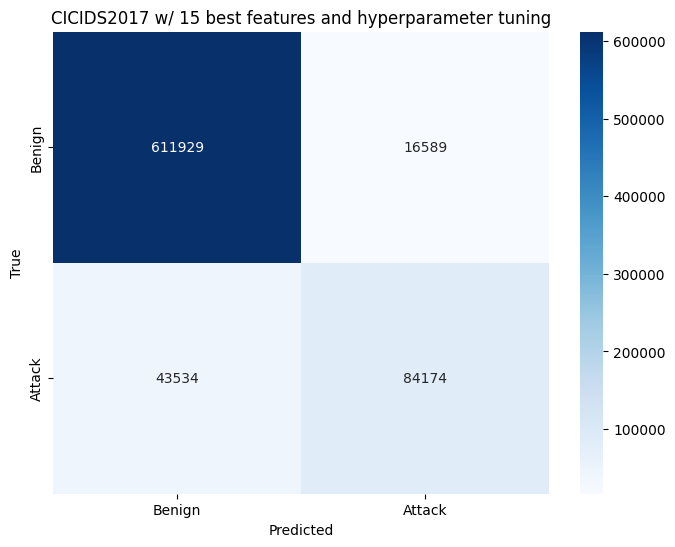

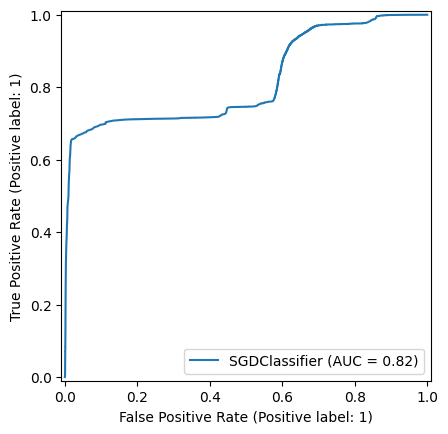

In [32]:
cic_clf = SGDClassifier(max_iter=5000, penalty='l1', loss='log_loss', alpha=0.0001)
train_model(cic_X_train_sel, cic_y_train, cic_X_test_sel, cic_y_test, cic_clf, title='CICIDS2017 w/ 15 best features and hyperparameter tuning')

### Cross Validation

In [12]:
# Crossvalidation function
def crossvalidate_model(clf, X_train, y_train):
    cv = StratifiedKFold(5)
    scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=cv)
    return scores

In [36]:
# Function to plot CV report
def plot_cv_report(scores, dataset, ylim_lower, ylim_upper):
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(scores) + 1), scores, width=0.4)
    plt.xlabel('CV Fold')
    plt.ylabel('Accuracy Score')
    plt.title(f'Cross-Validation Scores for {dataset}')
    
    mean_score = np.mean(scores)
    plt.axhline(y=mean_score, color='r', linestyle='-', label=f'Mean Score: {mean_score:.4f}')
    
    for i, score in enumerate(scores):
        plt.text(i + 1, score + 0.0001, f'{score:.4f}', ha='center')
    
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(ylim_lower, ylim_upper)

In [38]:
kdd_scores = crossvalidate_model(kdd_clf, kdd_X_train_sel, kdd_y_train)

In [39]:
cic_scores = crossvalidate_model(clf, cic_X_train, cic_y_train)

In [40]:
cic_scores

array([0.935935, 0.934395, 0.934875, 0.934615, 0.935205])

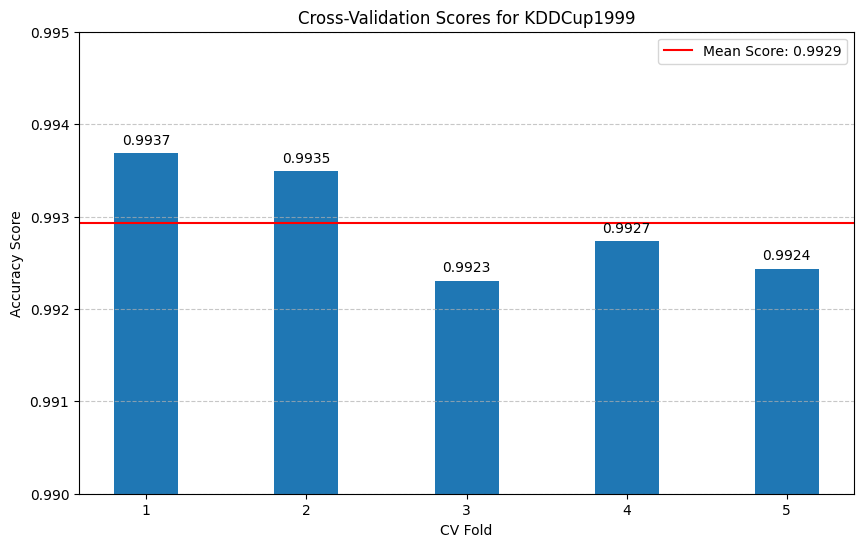

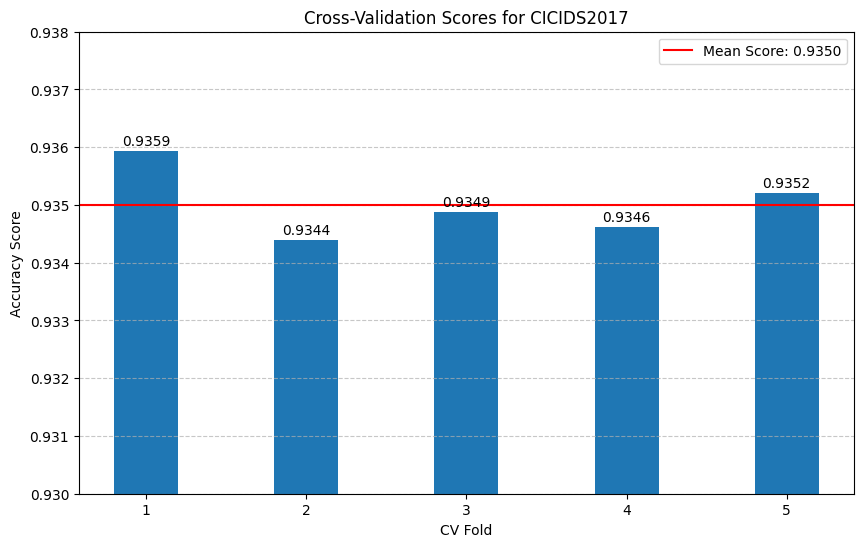

In [42]:
plot_cv_report(kdd_scores, 'KDDCup1999', 0.99, 0.995)
plot_cv_report(cic_scores, 'CICIDS2017', 0.93, 0.938)

## Explanations

In [132]:
# # Define a function to convert decision function to probabilities (sigmoid)
# def predict_proba_sgd(X):
#     decision_scores = clf.decision_function(X)  # Get decision function output
#     return 1 / (1 + np.exp(-decision_scores))  # Sigmoid to convert to probabilities

In [60]:
explainer_kdd = shap.KernelExplainer(kdd_clf.predict, kdd_X_train_sel[:100])
explainer_cic = shap.KernelExplainer(cic_clf.predict, cic_X_train_sel[:100])

#np.random.seed(42)
#sample_indices = np.random.choice(X_test_sel.shape[0], size=100000, replace=False)
#X_sample = X_test_sel.iloc[sample_indices]

kdd_shap_values = explainer_kdd(kdd_X_test_sel[100:200])
cic_shap_values = explainer_cic(cic_X_test_sel[100:200])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [61]:
np.shape(cic_shap_values)

(100, 15)

### KDD

#### Waterfall Plot

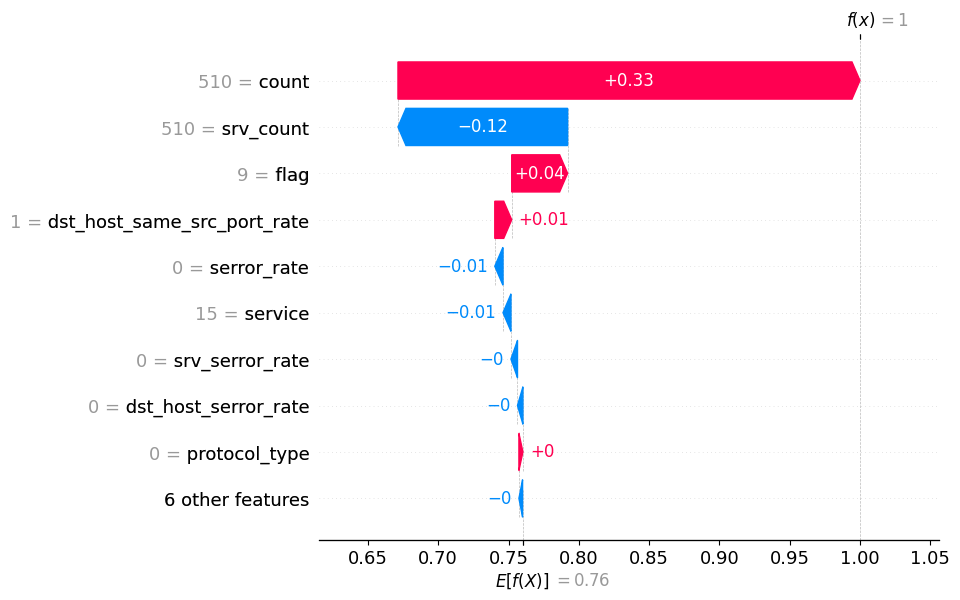

In [50]:
shap.plots.waterfall(kdd_shap_values[0])

#### Absolute Mean SHAP values

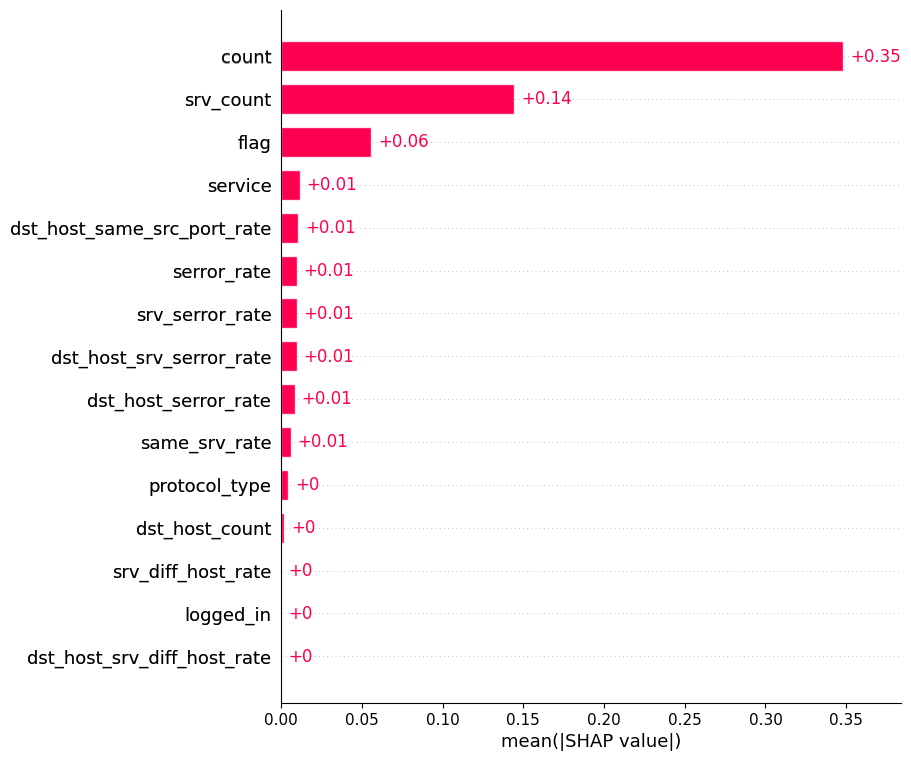

In [51]:
shap.plots.bar(kdd_shap_values, max_display=15)

#### Beeswarm plot

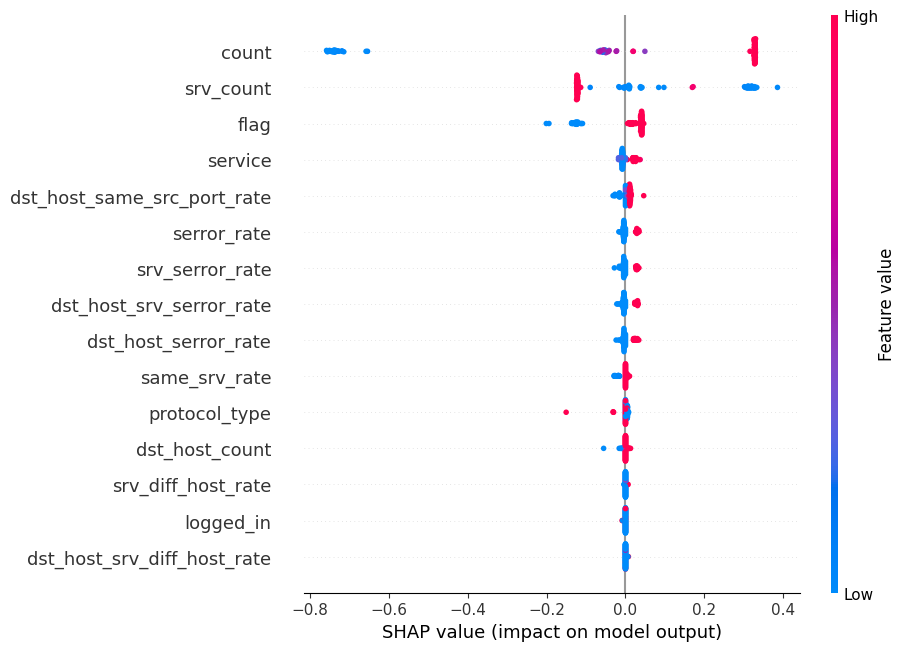

In [52]:
shap.plots.beeswarm(kdd_shap_values, max_display=15)

#### Dependence Plot

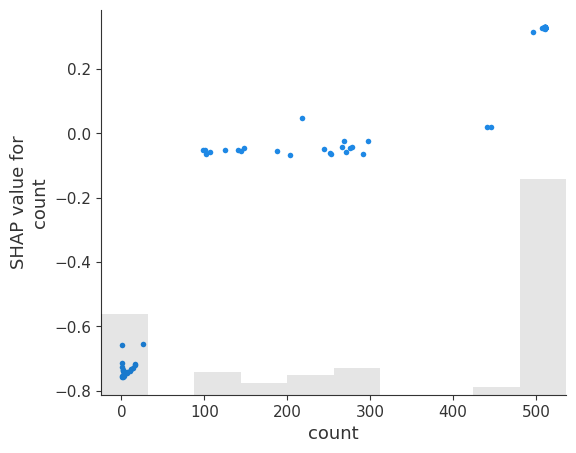

In [53]:
shap.plots.scatter(kdd_shap_values[:,"count"])

### CIC

#### Waterfall Plot

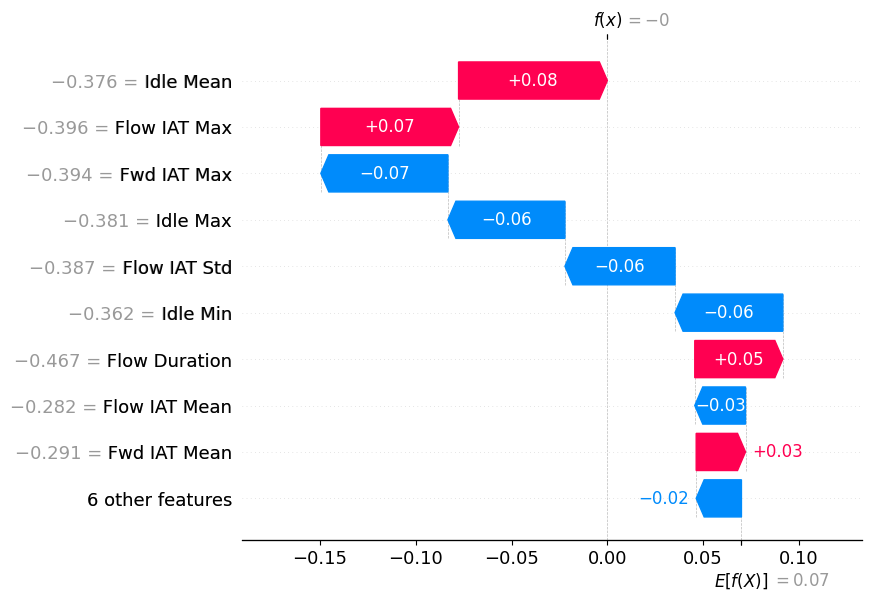

In [63]:
shap.plots.waterfall(cic_shap_values[0])

#### Absolute Mean SHAP values

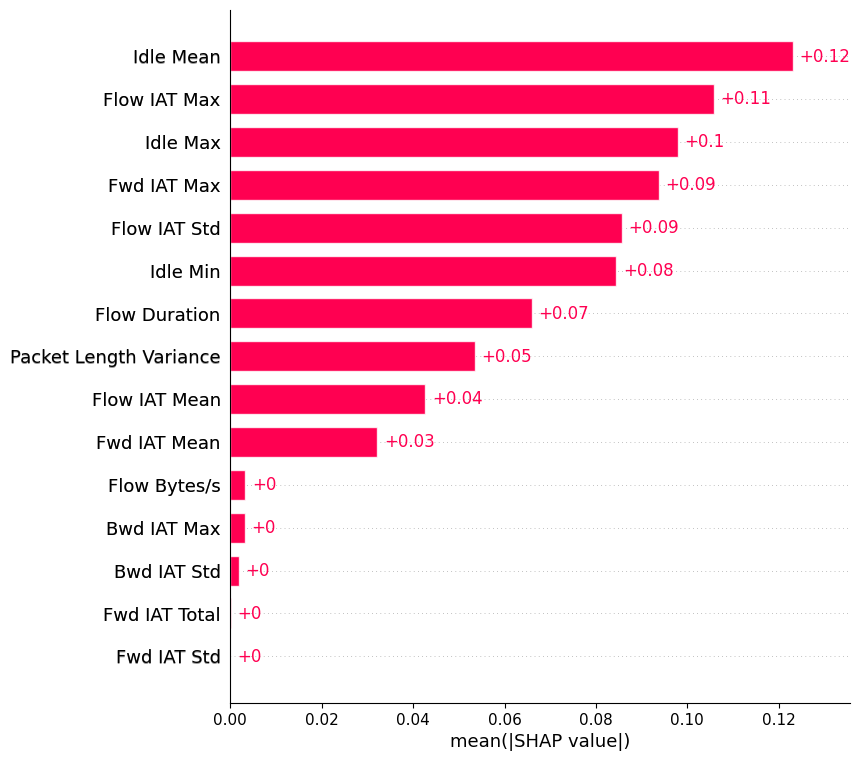

In [64]:
shap.plots.bar(cic_shap_values, max_display=15)

#### Beeswarm Plot

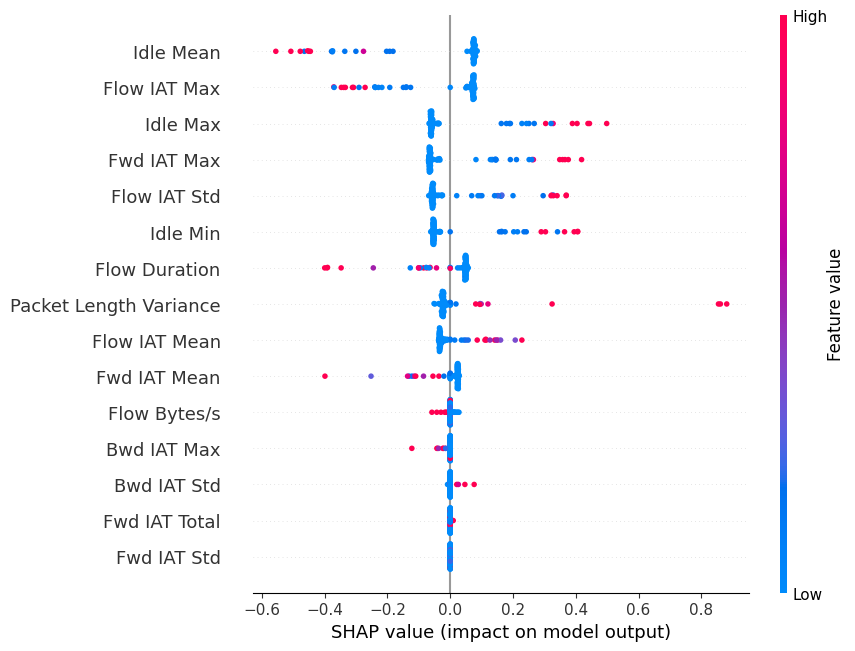

In [73]:
shap.plots.beeswarm(cic_shap_values, max_display=15)

#### Dependence Plot

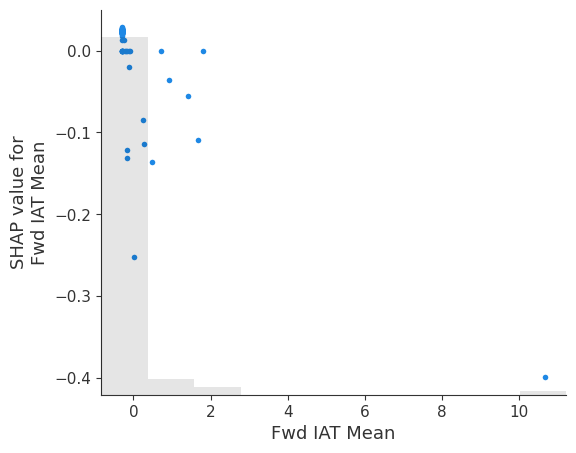

In [71]:
shap.plots.scatter(cic_shap_values[:,"Fwd IAT Mean"])